### Import Libraries

In [1]:
import torch
import torch.nn as nn
from IPython.display import Image

# visualisation
!pip install torchview
import torchvision
from torchview import draw_graph

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Conv block

In [34]:
class Dense_layer(nn.Module):
  """
    Implementation of conv layer Dense blocks
    bn + relu + conv1x1 --> bn + relu + conv3x3

    First 1x1 convolution generating 4*k number of channels irrespective of the total number of input channels.
    First 3x3 convolution generating k number of channels from the 4*k number of input channels.

    Parameters:
      in_channels (int) : # input channels to the Dense Layer

  """
  def __init__(self, in_channels):
    super(Dense_layer, self).__init__()

    self.bn1   = nn.BatchNorm2d(num_features=in_channels)
    self.relu1 = nn.ReLU()
    self.conv1= nn.Conv2d(in_channels, out_channels=4*k, kernel_size=1, stride=1)

    self.bn2   = nn.BatchNorm2d(num_features=4*k)
    self.relu2 = nn.ReLU()
    self.conv2= nn.Conv2d(in_channels=4*k, out_channels=k, kernel_size=3, stride=1, padding=1)


  def forward(self, x):
    """
      Bottleneck DenseLayer with following operations
      (i) batchnorm -> relu -> 1x1 conv
      (ii) batchnorm -> relu -> 3x3 conv

      Concatenation of input and output tensor which is the main idea of DenseNet.

      Parameters:
          x (tensor) : input tensor to be passed through the dense layer

      Returns:
          x (tensor) : output tensor

    """
    input = x
    x = self.conv1(self.relu1(self.bn1(x)))
    x = self.conv2(self.relu2(self.bn2(x)))
    x = torch.cat([input, x],1)
    return x


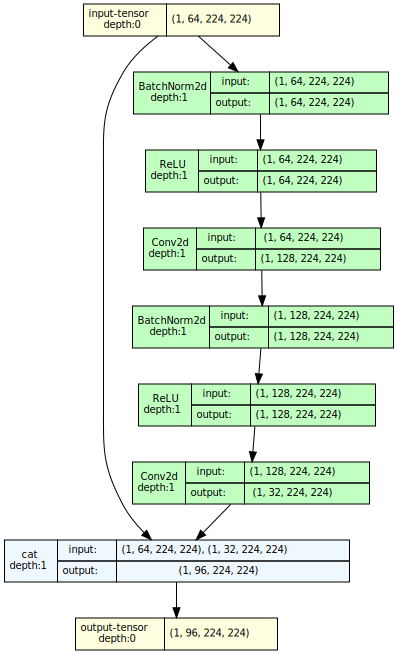

In [38]:
def test_DenseLayer():
    x = torch.randn(1,64,224,224)
    model = Dense_layer(64)
    # print(model(x).shape)
    # print(model)
    # del model
    return model


model = test_DenseLayer()

architecture = 'denselayer'
model_graph = draw_graph(model, input_size=(1,64,224,224),expand_nested=True)
model_graph.visual_graph

In [43]:
class Dense_block(nn.Module):
  """
    Looping through total number of layers in the denseblock.
    Adding k number of channels in each loop as each layer generates tensor with k channels.

    Args:
        layer_num (int) : total number of dense layers in the dense block
        in_channels (int) : input number of channels
  """
  def __init__(self, layer_num, in_channels):
    super(Dense_block, self).__init__()
    self.layer_num = layer_num
    self.deep_nn = nn.ModuleList()

    for num in range(self.layer_num):
            self.deep_nn.add_module(f"DenseLayer_{num}",Dense_layer(in_channels + k*num))


  def forward(self,x):
      """
      Args:
          x (tensor) : input tensor to be passed through the dense block

      Attributes:
          x (tensor) : output tensor
      """
      input = x
      print('xin shape',input.shape)

      for layer in self.deep_nn:
          x = layer(x)
          print('xout shape',x.shape)
      return x




In [47]:
# def test_DenseBlock():
#     x = torch.randn(1,3,224,224)
#     model = Dense_block(3,3)
#     print('Denseblock Output shape : ',model(x).shape)
#     print('Model ',model)
#     # del model
#     return model


# model = test_DenseBlock()

# architecture = 'denseblock'
# model_graph = draw_graph(model, input_size=(1,3,224,224),expand_nested=True)
# model_graph.visual_graph


In [49]:
class Transition_block(nn.Module):
  """
    1x1 conv used to change output channels using the compression_factor (default = 0.5).
    avgpool used to downsample the feature map resolution

    Args:
        compression_factor (float) : output_channels/input_channels
        in_channels (int) : input number of channels
  """
  def __init__(self, in_channels, compression_factor):
    super(Transition_block, self).__init__()
    self.bn = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels=int(in_channels*compression_factor), kernel_size=1, stride=1)
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    """
        Args:
            x (tensor) : input tensor to be passed through the dense block

        Attributes:
            x (tensor) : output tensor
    """
    x = self.conv(self.relu(self.bn(x)))
    x = self.pool(x)
    return x

Transition Layer Output shape :  torch.Size([1, 32, 112, 112])
Model :  Transition_block(
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)


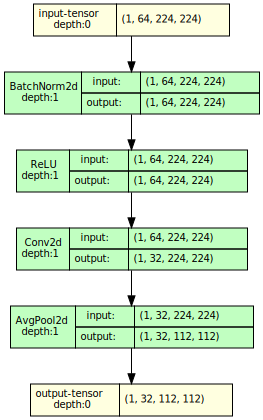

In [52]:
def test_TransitionLayer():
    x = torch.randn(1,64,224,224)
    model = Transition_block(64,compression_factor)
    print('Transition Layer Output shape : ',model(x).shape)
    print('Model : ',model)
    return model


model = test_TransitionLayer()
architecture = 'transition'
model_graph = draw_graph(model, input_size=(1,64,224,224),expand_nested=True)
model_graph.visual_graph

In [41]:
class DenseNet(nn.Module):
  def __init__(self,densenet_variant,in_channels,num_classes=1000):

    """
    Creating an initial 7x7 convolution followed by 3 DenseBlock and 3 Transition layers. Concluding this with 4th DenseBlock, 7x7 global average pool and FC layer
    for classification
    Args:
        densenet_variant (list) : list containing the total number of layers in a dense block
        in_channels (int) : input number of channels
        num_classes (int) : Total nnumber of output classes

    """

    super(DenseNet,self).__init__()

    # 7x7 conv with s=2 and maxpool
    self.conv1 = nn.Conv2d(in_channels=in_channels ,out_channels=64 ,kernel_size=7 ,stride=2 ,padding=3 ,bias = False)
    self.BN1 = nn.BatchNorm2d(num_features=64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)


    # adding 3 DenseBlocks and 3 Transition Layers
    self.deep_nn = nn.ModuleList()
    dense_block_inchannels = 64

    # [6,12,24,16]
    for num in range(len(densenet_variant))[:-1]:

        self.deep_nn.add_module( f"DenseBlock_{num+1}" , Dense_block( densenet_variant[num] , dense_block_inchannels ) )
        dense_block_inchannels  = int(dense_block_inchannels + k*densenet_variant[num])

        self.deep_nn.add_module( f"TransitionLayer_{num+1}" , Transition_block( dense_block_inchannels,compression_factor ) )
        dense_block_inchannels = int(dense_block_inchannels*compression_factor)

    # adding the 4th and final DenseBlock
    self.deep_nn.add_module( f"DenseBlock_{num+2}" , Dense_block( densenet_variant[-1] , dense_block_inchannels ) )
    dense_block_inchannels  = int(dense_block_inchannels + k*densenet_variant[-1])

    self.BN2 = nn.BatchNorm2d(num_features=dense_block_inchannels)

    # Average Pool
    self.average_pool = nn.AdaptiveAvgPool2d(1)

    # fully connected layer
    self.fc1 = nn.Linear(dense_block_inchannels, num_classes)


  def forward(self,x):
    """
    deep_nn is the module_list container which has all the dense blocks and transition blocks
    """
    x = self.relu(self.BN1(self.conv1(x)))
    x = self.maxpool(x)

    for layer in self.deep_nn:
        x = layer(x)

    x = self.relu(self.BN2(x))
    x = self.average_pool(x)

    x = torch.flatten(x, start_dim=1)
    x = self.fc1(x)

    # print(x.shape)
    return x


In [42]:
densenet121 = [6,12,24,16]
k = 32 # growth rate
compression_factor = 0.5


x = torch.randn(1,3,224,224)
model = DenseNet(densenet121,3)

architecture = 'denseNet'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=False, expand_nested=True, show_shapes=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graphfor i, num_layers in enumerate((6,12,24,16)):
  # print(i, num_layers)

xin shape torch.Size([1, 64, 56, 56])
xout shape torch.Size([1, 96, 56, 56])
xout shape torch.Size([1, 128, 56, 56])
xout shape torch.Size([1, 160, 56, 56])
xout shape torch.Size([1, 192, 56, 56])
xout shape torch.Size([1, 224, 56, 56])
xout shape torch.Size([1, 256, 56, 56])
xin shape torch.Size([1, 128, 28, 28])
xout shape torch.Size([1, 160, 28, 28])
xout shape torch.Size([1, 192, 28, 28])
xout shape torch.Size([1, 224, 28, 28])
xout shape torch.Size([1, 256, 28, 28])
xout shape torch.Size([1, 288, 28, 28])
xout shape torch.Size([1, 320, 28, 28])
xout shape torch.Size([1, 352, 28, 28])
xout shape torch.Size([1, 384, 28, 28])
xout shape torch.Size([1, 416, 28, 28])
xout shape torch.Size([1, 448, 28, 28])
xout shape torch.Size([1, 480, 28, 28])
xout shape torch.Size([1, 512, 28, 28])
xin shape torch.Size([1, 256, 14, 14])
xout shape torch.Size([1, 288, 14, 14])
xout shape torch.Size([1, 320, 14, 14])
xout shape torch.Size([1, 352, 14, 14])
xout shape torch.Size([1, 384, 14, 14])
xout 